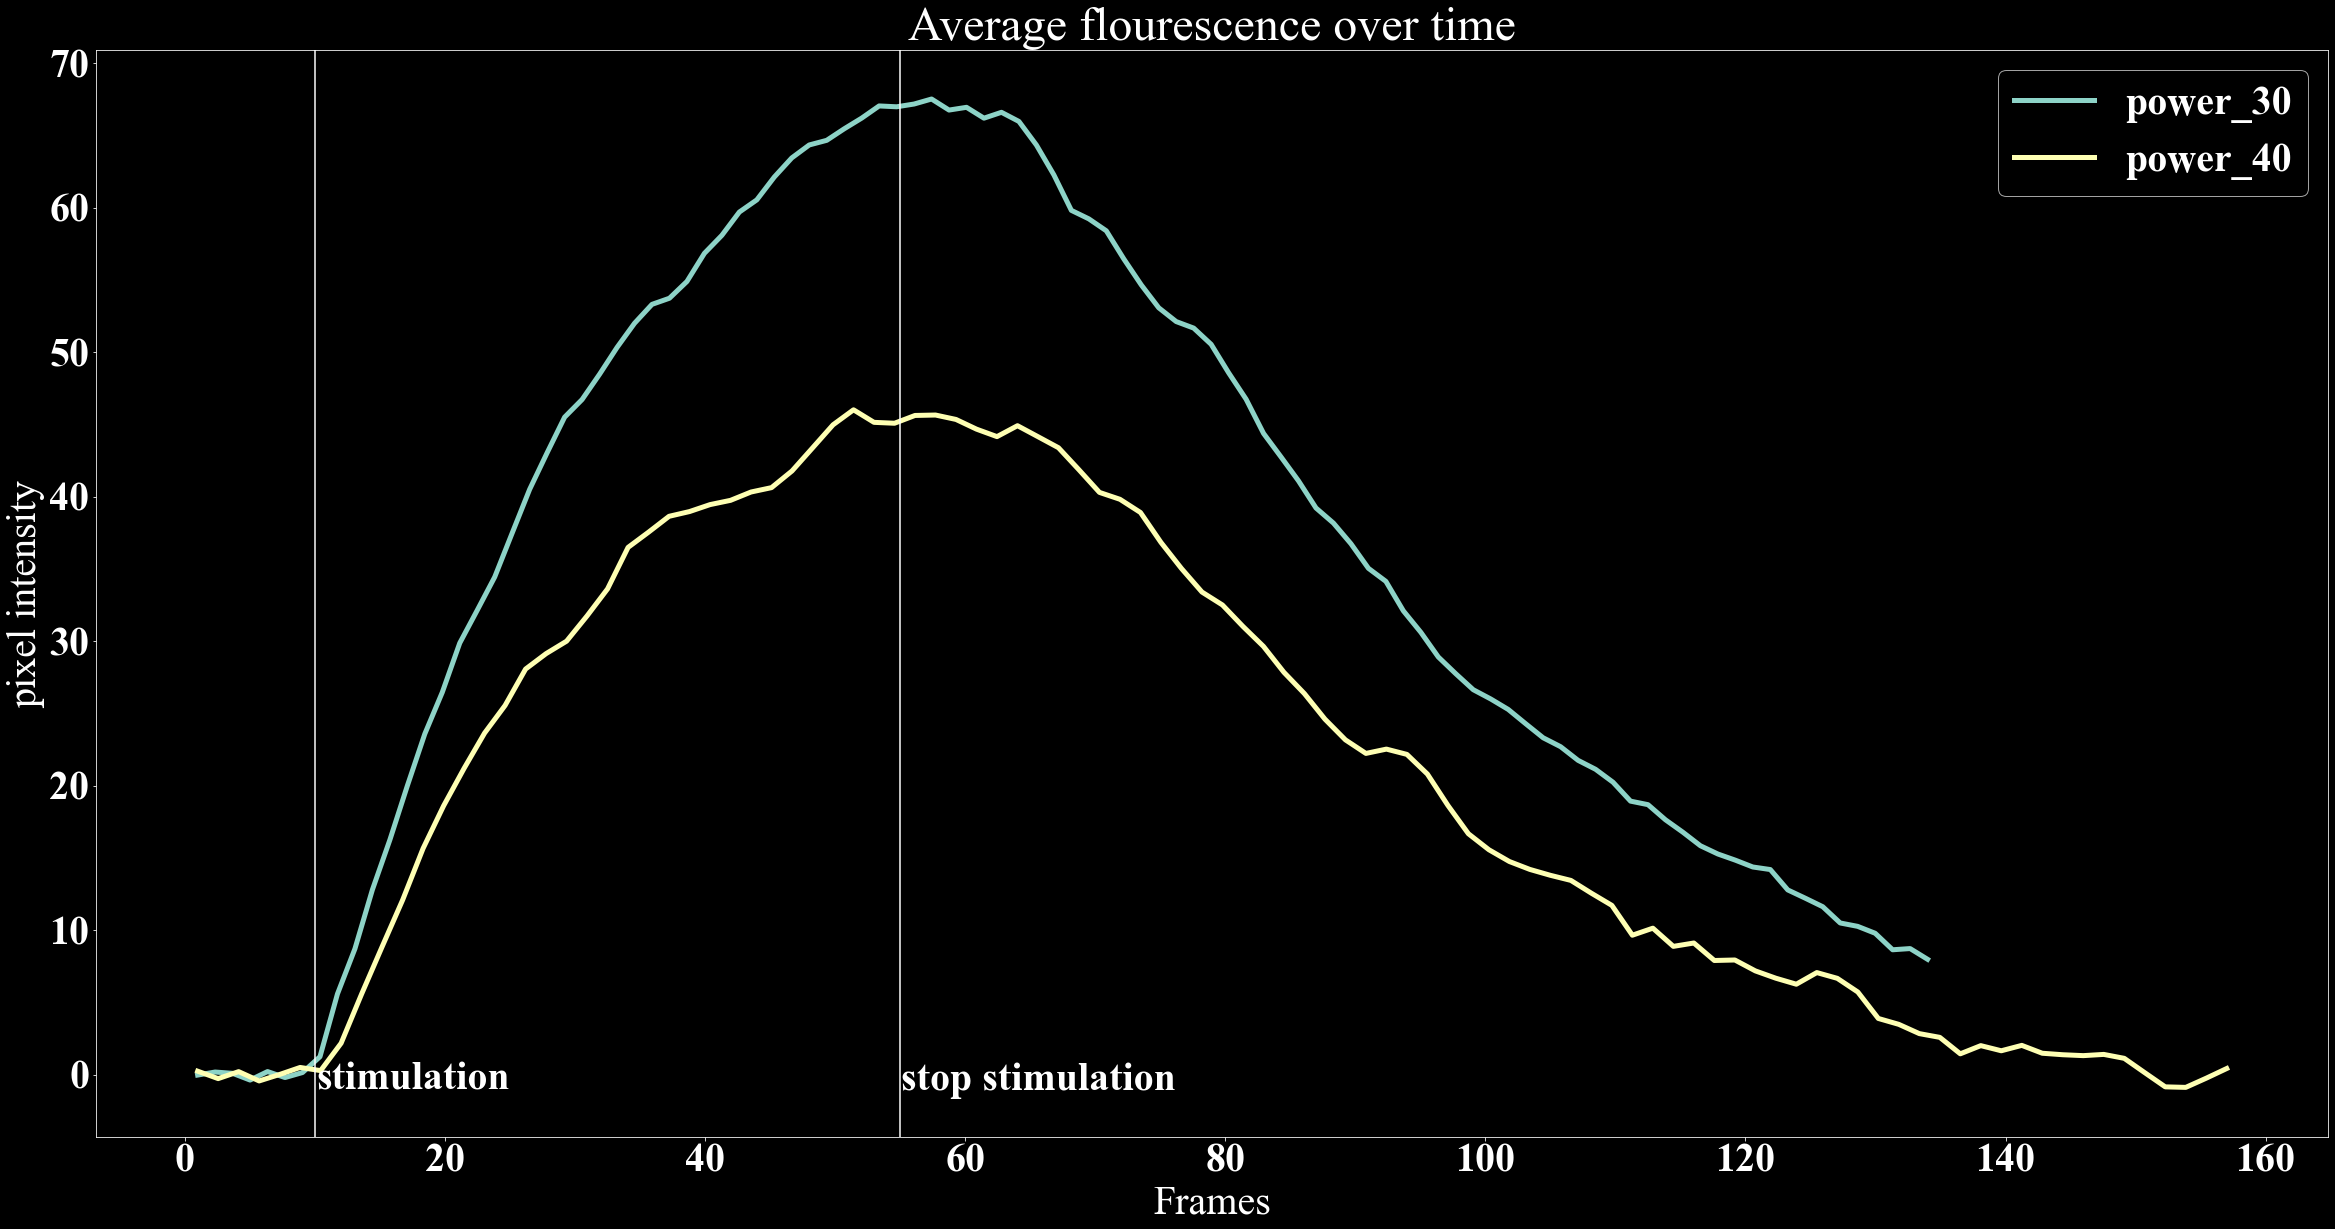

In [4]:
import glob,os
import sys
import math                   
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import skimage.io as skio
from skimage.morphology import disk, binary_erosion, binary_dilation, binary_opening, binary_closing, remove_small_objects
from skimage.restoration import rolling_ball 
from skimage.filters import gaussian
from skimage.measure import label
import tkinter as tk
from tkinter import Tk
from tkinter import ttk
import pyclesperanto_prototype as cle

"""This script calculates the average flouresence over time for provided movies. The movies should only be one channel. It will
calc the avg flour of each frame, and give raw, normalized (-avg raw value of the first frames (no stimulation)), and rolling average 
where the number of frames averaged is provided by the user (the pre-stim frames are not rolled, to allow for obvious stimulation 
time). User must also prvoide the number of pre-stimulation frames.

You can also change whether the masks for each movie are plotted and whether the raw, normalized, or rolling_norm data is plotted
below"""

os.chdir("/Users/domchom/Desktop/Python_Learning/Projects/Avg_flour_over_time_filtered/test_image_process_datasets") #paste the pathname for your movies of interest
roll_avg_frames = 5 #how many frames to average together (1 = just raw data data, no averaging)
pre_stim_frames = 10
what_to_plot =  'rolling_norm' #either 'raw', 'normalized', or 'rolling_norm'

######################################
########## ERRORS ######## ###########
######################################

if roll_avg_frames < 1: #error message if the user tries to average less than one frame
    print("You cannot average less than 1 frame!")

######################################
########## PROCESSING ################
######################################
 
fileNames = [] #list for each of the file names
for file in glob.glob("*.tif"): #obtaining the name of each file that ends in ".tif" in the provided directory
    fileNames.append(file)
    fileNames.sort()
    
##### Below used to calculate the RAW average intensity for each frame in each movie 
raw = {} #dictionary to store the raw total intensity value per frame for each file
for file in fileNames: #iterate over each file in the list of file names
    movie = skio.imread(file) #read each movie
    movie = movie[:-1] #remove the last frame of each movie
    avg_pix_int_per_frame = () #tuple that will contain the average pixel intensity of each frame
    i = 0 
    
    ##### Below is used for selecting the edge of the cell (not perfect) by selecting the highest pixel values after 50 frames
    single_frame = cle.create([512, 512]);
    frame = 50;
    cle.copy_slice(movie, single_frame, frame) #creates an image of a single slice of the movie at frame = 50
    mask = single_frame > np.mean(single_frame)*2.5 #masked the image
    blurred = gaussian(mask, 5) #blurring that first mask
    edge = blurred > np.mean(blurred)*5 #masking again
    edge_eroded4 = binary_erosion(edge, disk(4)) #to help with binary erosion
    labeled_edge_eroded4 = label(edge_eroded4, connectivity=2) #for labelling the structures
    #cle.imshow(labeled_edge_eroded4, labels=True)


    edge_only = remove_small_objects(edge_eroded4, min_size=5000) #filtering out the smaller regions, like membrane folds
    #labeled_edge_only = label(edge_only, connectivity=2)
    #cle.imshow(labeled_edge_only, labels = True)
    
    for one_frame in movie: #iterate over each frame calc the average pixel intensity per frame; assign the tuple created above
        masked = one_frame * edge_only
        i += 1 #increasing frame number
        intensity = np.mean(masked) #calc the mean intensity
        avg_pix_int_per_frame = avg_pix_int_per_frame + (intensity,) #add to the tuple above
    raw[file] = avg_pix_int_per_frame #file name is the key; average pixel intensity per frame stored as tuple is the value

##### Below used to calculate the NORMALIZED average intensity for each frame in each movie 
normalized = {} #dictionary to store the normalized total intensity value per frame for each file
for profile in raw: #iterate over each movie profile and normalize to the first frame; store in new dict above
    pre_stim_value = sum(raw[profile][:pre_stim_frames])/pre_stim_frames #finding the average intensity level of the pre-stim frames for normalizing
    normal_int_profile = () #tuple to store he normalized average pixel intensity of each frame
    for raw_avg_int in raw[profile]: #iterate over the profile for each movie and normalize each frame
        norm_avg_int = raw_avg_int - pre_stim_value #normalize
        normal_int_profile = normal_int_profile + (norm_avg_int,) #new profile
    normalized[profile] = normal_int_profile #store normalized profile in new dict
        
##### Below used to calculate the ROLLING NORMALIZED average intensity for each frame in each movie 
rolling_norm = {} #dictionary to contain the rolling normalized intensity profiles for each movie
for profile in normalized: #for each intensity value in the tuple "value" of the dictinary
    rolling_int_profile = ()
    i = 0
    for norm_avg_int in normalized[profile]:
        i += 1
        rolling_total = norm_avg_int #used to calculate the rolling avg intensity 
        if i < pre_stim_frames + 1: #pre stim frames will not be rolled
            rolling_int_profile = rolling_int_profile + (rolling_total,)
            continue
        elif i < len(normalized[profile]) - roll_avg_frames: # to keep the system in the correct range
            for w in range(roll_avg_frames - 1): #for loop to add the correct number of frames to the running total
                w += 1 
                rolling_total = rolling_total + normalized[profile][i - 1 + w]
            rolling_average = rolling_total / roll_avg_frames #taking the average of the selected frames
            rolling_int_profile = rolling_int_profile + (rolling_total,) #final rolling normalized average intensity values added to one tuple per movie
        else:
            break
    rolling_norm[profile] = rolling_int_profile # the tuple is added to the dictionary with the file name as the key
    
##### Below creates three csv files: raw, normailzed, and rolling normalized profiles for each movie
with open('!raw_values.csv', 'w') as f:
    for key in raw.keys():
        f.write("%s,%s\n"%(key,raw[key]))

with open('!normalized_values.csv', 'w') as f:
    for key in normalized.keys():
        f.write("%s,%s\n"%(key,normalized[key]))

with open(f'!rolling({roll_avg_frames})_normalized_values.csv', 'w') as f:
    for key in rolling_norm.keys():
        f.write("%s,%s\n"%(key,rolling_norm[key]))
        
##### Below is code for plotting the intensity over time for each profile on the same graph
def plot_profiles(dict_of_profiles):
    for movie in dict_of_profiles: #for each file in dictionary or normalized intensities
        i = 0
        One_movie_profile = {} #dictionairy to contain the normalized intensity profile for the one movie that that this for loop is currently working on
        for roll_norm_int in dict_of_profiles[movie]: #for each intensity value in the tuple "value" of the dictinary
            i += 1 #frame number
            One_movie_profile[i] = roll_norm_int #final rolling normalized average intensity value
        myList = One_movie_profile.items() #items() returns a view object. The view object contains the key-value pairs of the dictionary, as tuples in a list.
        x, y = zip(*myList) #zip(*iterables) --> A zip object yielding tuples until an input is exhausted.

        #smoothing the line 
        x = np.array(x) #converting to a numpy array
        y = np.array(y) #converting to a numpy array
        x_new = np.linspace(x.min(), x.max(), 100) #max is max, min is min, data avergaed into ______ bins
        bspline = scipy.interpolate.make_interp_spline(x, y)
        y_new = bspline(x_new)
        plt.plot(x_new, y_new, linewidth=5)
    
if what_to_plot == 'raw':
    plot_profiles(raw)
    plotted = 'raw'
elif what_to_plot == 'normalized':
    plot_profiles(normalized)
    plotted = 'normalized'
elif what_to_plot == 'rolling_norm':
    plot_profiles(rolling_norm)
    plotted = 'rolling_norm'
else:
    print(f'{what_to_plot} is not valid')
    
legend = ' '.join(fileNames)
legend_new = legend.replace('.tif', '')
legend_new = legend_new.split(' ')

plt.xlabel('Frames')
plt.ylabel(f'pixel intensity')
plt.title('Average flourescence over time')
plt.legend(legend_new)
plt.rcParams["figure.figsize"] = (40,20)
plt.style.use('dark_background')
plt.axvline(pre_stim_frames)
plt.text(pre_stim_frames+.1,-1,'stimulation',rotation=0)
plt.axvline(55)
plt.text(pre_stim_frames+45.1,-1,'stop stimulation',rotation=0)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 40}

plt.rc('font', **font)
plt.savefig(f'!intensity_profiles_{plotted}.png')
plt.show()